# Load model and make predictions (find roads)

### Redefining model 

In [15]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

"""
One convolution setion of the UNET
"""
class Section(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(Section, self).__init__()
        self.process = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same'),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.process(x)
    
"""
UNET implementation
"""
class UNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super(UNET, self).__init__()
        # Contraction
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down1 = Section(in_channels=in_channels, out_channels=64)
        self.down2 = Section(in_channels=64, out_channels=128)
        self.down3 = Section(in_channels=128, out_channels=256)
        self.down4 = Section(in_channels=256, out_channels=512)
        self.down5 = Section(in_channels=512, out_channels=1024)
        # Expansion
        self.up_conv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up1 = Section(in_channels=1024, out_channels=512, kernel_size=3)
        self.up2 = Section(in_channels=512, out_channels=256, kernel_size=3)
        self.up3 = Section(in_channels=256, out_channels=128, kernel_size=3)
        self.up4 = Section(in_channels=128, out_channels=64, kernel_size=3)
        # Output 
        self.output = nn.Conv2d(64, out_channels, kernel_size=1, padding='same')
        
    def forward(self, x):
        skip_connections = []
        #Contraction
        # down1
        x = self.down1(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down2
        x = self.down2(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 3
        x = self.down3(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 4
        x = self.down4(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 5
        x = self.down5(x)
        
        #Expansion
        # up1
        x = self.up_conv1(x)
        y = skip_connections[3]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up1(y_new)
        # up2
        x = self.up_conv2(x)
        y = skip_connections[2]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up2(y_new)
        # up3
        x = self.up_conv3(x)
        y = skip_connections[1]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up3(y_new)
        # up4 
        x = self.up_conv4(x)
        y = skip_connections[0]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up4(y_new)
        x = self.output(x)
        return x

### Loading the model

In [16]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu" # Can be done without gpu
model = torch.load('model.pth', map_location=torch.device(device))
model.to(device="cuda")

UNET(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down1): Section(
    (process): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
    )
  )
  (down2): Section(
    (process): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
    )
  )
  (down3): Section(
    (process): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
    )
  )
  (down4): Section(
    (process): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=

### Predicting 

In [17]:
# Load and see image to predict

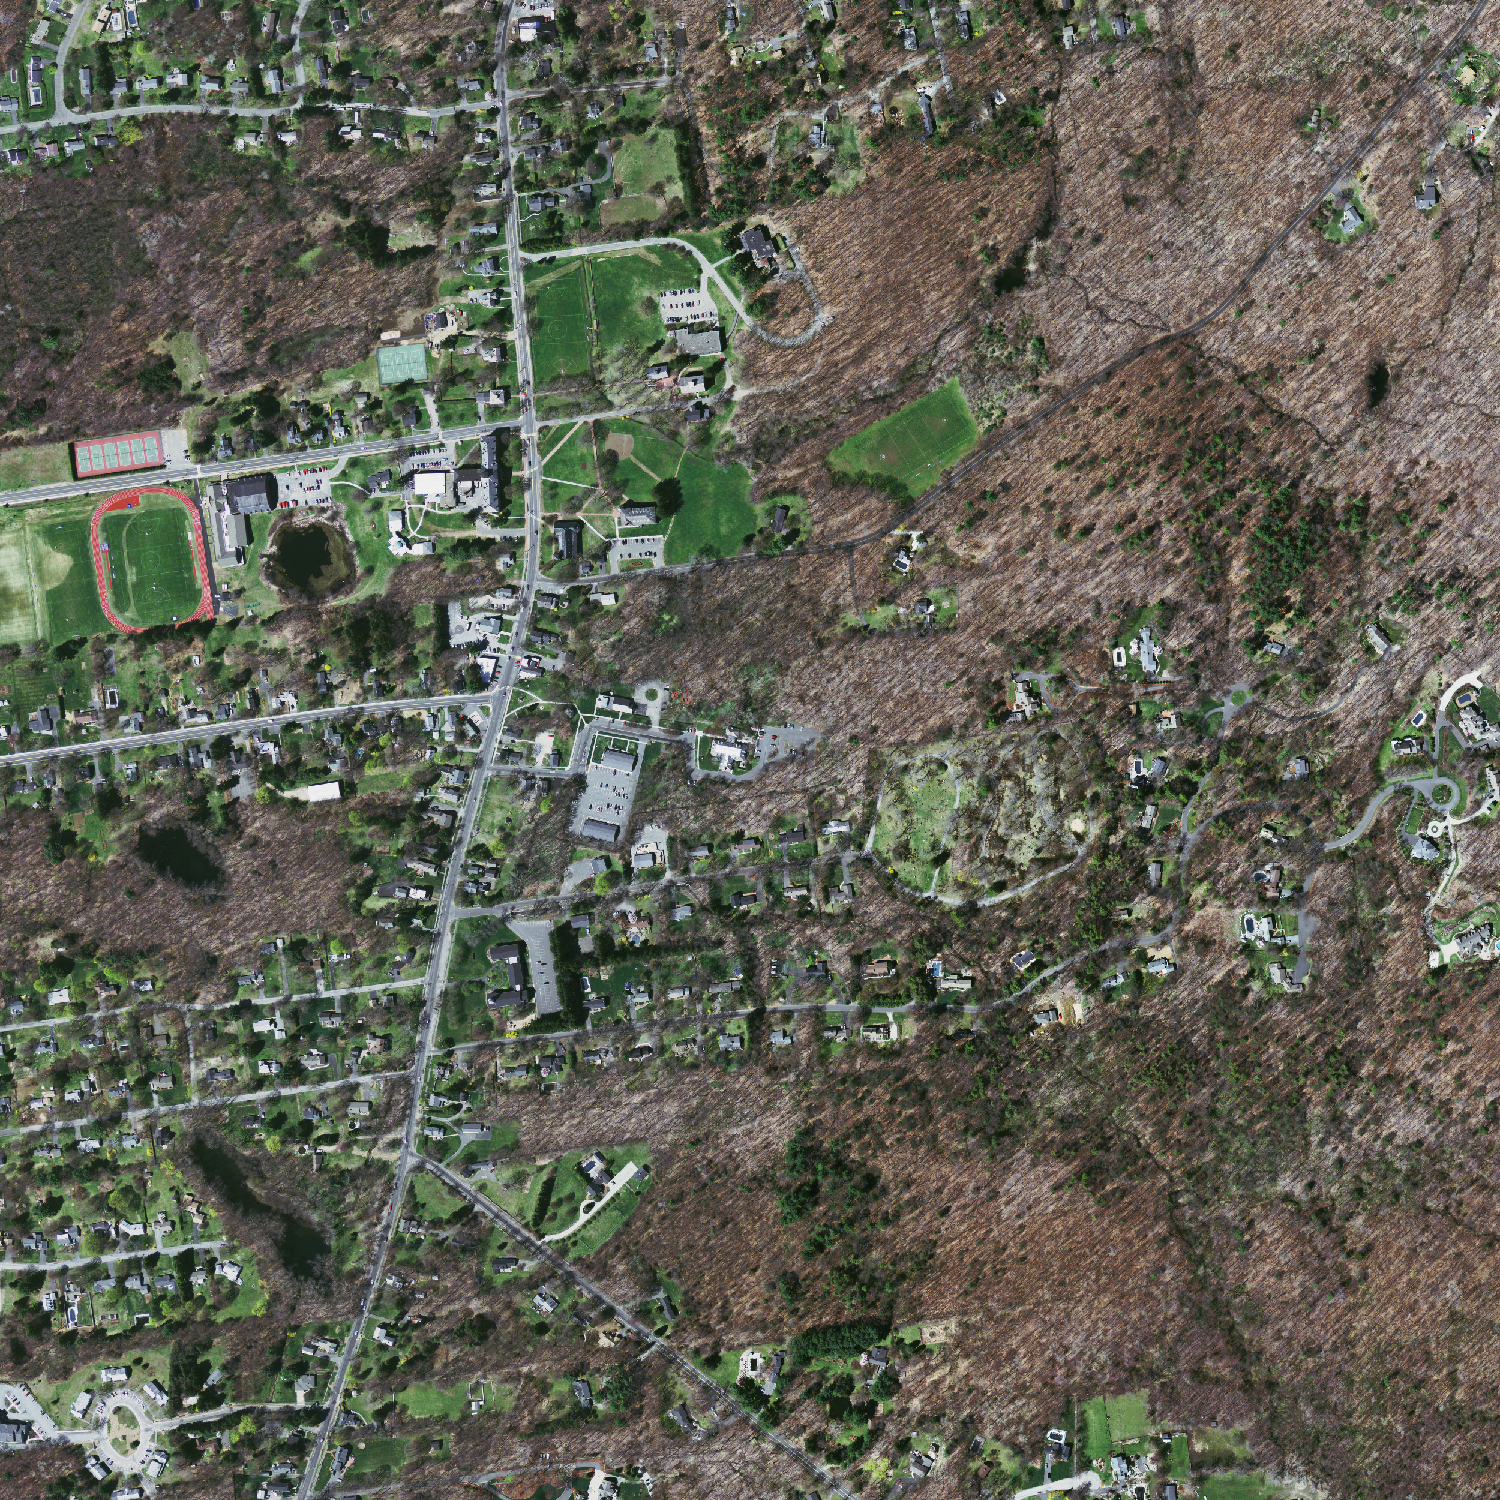

In [18]:
from PIL import Image
image = Image.open('/home/ubuntu/segmentation/mass_roads/test/sat/12328750_15.tiff').convert("RGB")
image.show()

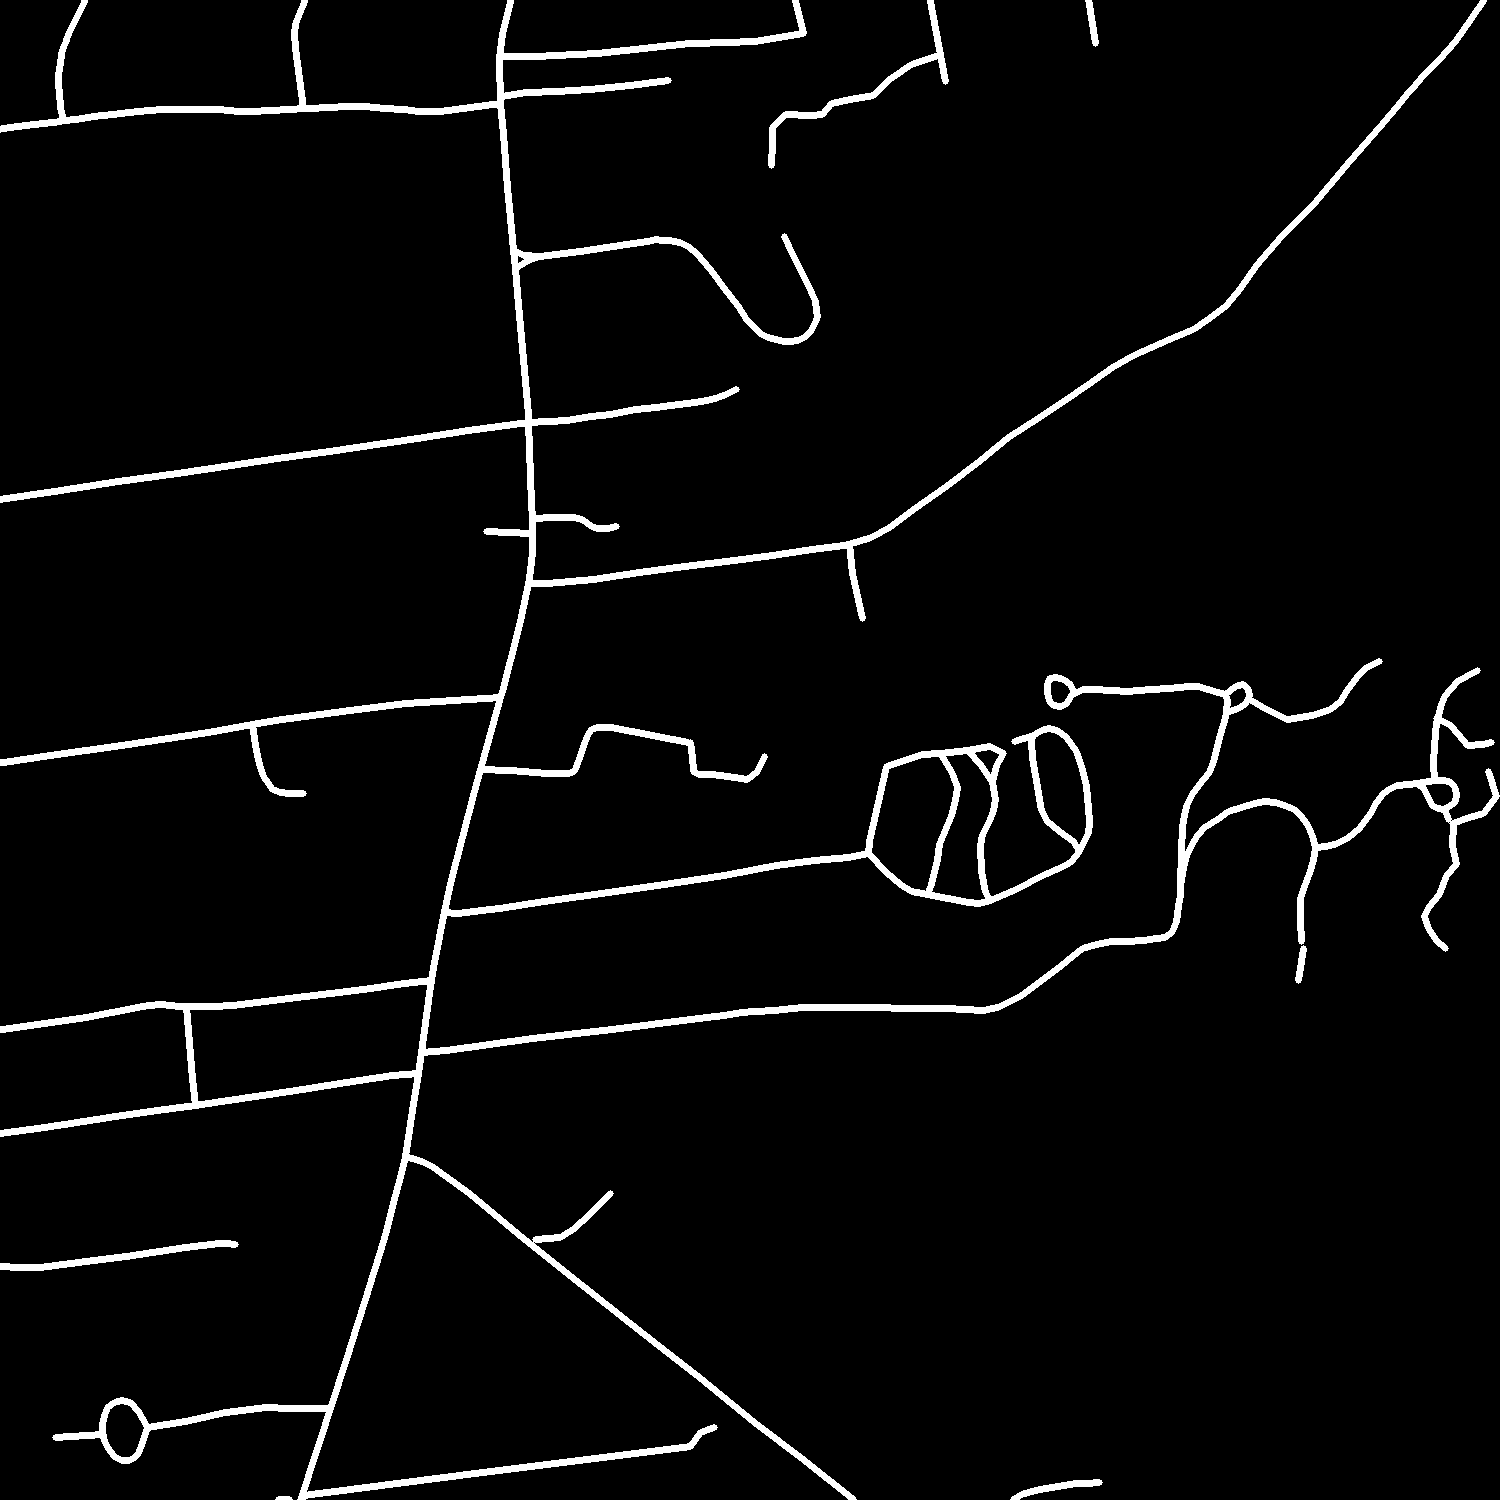

In [19]:
# Looking at actual map
map_actual = Image.open('/home/ubuntu/segmentation/mass_roads/test/map/12328750_15.tif').convert("L")
map_actual.show()

In [20]:
# convert image to tensor
import torchvision.transforms as tf
toTensor = tf.Compose([
    tf.ToTensor()
])
image_input = toTensor(image)
image_input = image_input.resize(1,3,1500,1500)
image_input.shape

torch.Size([1, 3, 1500, 1500])

In [21]:
image_input.to(device=device)
with torch.no_grad():
            preds = torch.sigmoid(model(image_input))
            preds = (preds > 0.19).float()

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
toPilT = tf.Compose([
    tf.ToPILImage()
])
image_preds = toPilT(preds[0])
image_preds.show()